# Reproduce: Schmidt et al., Phys. Rev. B 82, 100507(R) (2010)

J.R. Johansson, robert@riken.jp, http://dml.riken.jp/~rob/

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from qutip import *

# Introduction

This notebook reproduces some of the results in [S. Schmidt et al., Phys. Rev. B 82, 100507(R) (2010)](http://dx.doi.org/10.1103/PhysRevB.82.100507) using QuTiP.

## Problem parameters


Here we use units where $\hbar = 1$: 

In [3]:
N = 21              # number of cavity fock states
nn = N-1

wc = ones(2) * 1.00 * 2 * pi        # cavity frequency
wa = ones(2) * 1.00 * 2 * pi         # atom frequency
J  = 0.01 * 2 * pi            # coupling strength: cavity-cavity

# localization threshold is 2.8 * sqrt(nn) * J
gc = 2.8 * sqrt(nn) * J

g  = ones(2) * gc * 2.0   # coupling strength: atom-cavity
kappa = ones(2) * 0.01 * J/(2*pi)      # cavity dissipation rate
gamma = ones(2) * 0.01 * J/(2*pi)      # atom dissipation rate

n_th = 0.0         # avg number of thermal bath excitation

T = 10 / (J/(2*pi))
tlist = linspace(0, T, 1001)

## Setup the operators, the Hamiltonian and initial state

In [4]:
# start with a fock state witn nn photons in cavity #1
psi0 = tensor(basis(N,nn), basis(2,0), basis(N,0), basis(2,0))
#psi0 = tensor(coherent(N,sqrt(nn)), basis(2,0), basis(N,0), basis(2,0))

In [5]:
# cavity annihilation operator
C = [tensor(destroy(N), qeye(2), qeye(N), qeye(2)), tensor(qeye(N), qeye(2), destroy(N), qeye(2))]

# atomic annihilation operator
A = [tensor(qeye(N), destroy(2), qeye(N), qeye(2)), tensor(qeye(N), qeye(2), qeye(N), destroy(2))]

# number operators
NA = array([a.dag() * a for a in A])
NC = array([c.dag() * c for c in C])

# polariton operators
P = NA + NC

In [6]:
# Jaynes-Cumming Hamiltonian for system 0
H0c = wc[0] * C[0].dag() * C[0] 
H0a = wa[0] * A[0].dag() * A[0]
H0int = g[0] * (A[0].dag() * C[0] + A[0] * C[0].dag())
H0 = H0c + H0a + H0int

# Jaynes-Cumming Hamiltonian for system 1
H1c = wc[1] * C[1].dag() * C[1]
H1a = wa[1] * A[1].dag() * A[1] 
H1int = g[1] * (A[1].dag() * C[1] + A[1] * C[1].dag())
H1 = H1c + H1a + H1int

# cavity-cavity interaction
Hint = J * (C[0].dag() * C[1] + C[0] * C[1].dag())

H = H0 + H1 + Hint

In [7]:
H

Quantum object: dims = [[21, 2, 21, 2], [21, 2, 21, 2]], shape = [1764, 1764], type = oper, isherm = True
Qobj data =
[[   0.            0.            0.         ...,    0.            0.            0.        ]
 [   0.            6.28318531    1.5735585  ...,    0.            0.            0.        ]
 [   0.            1.5735585     6.28318531 ...,    0.            0.            0.        ]
 ..., 
 [   0.            0.            0.         ...,  257.61059759
     7.03716754    0.        ]
 [   0.            0.            0.         ...,    7.03716754
   257.61059759    0.        ]
 [   0.            0.            0.         ...,    0.            0.
   263.8937829 ]]

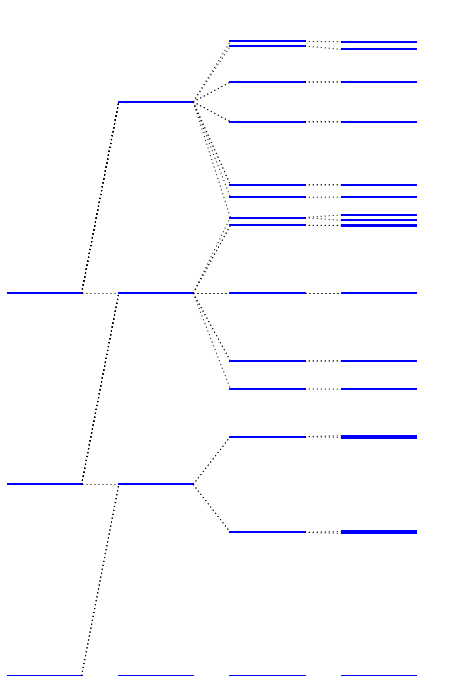

In [8]:
energy_level_diagram([H0c + H1c, H0a + H1a, H0int + H1int, Hint], 23);

## Create a list of collapse operators that describe the dissipation

In [9]:
c_ops = []

# cavity relaxation
for i in [0,1]:
    rate = kappa[i] * (1 + n_th)
    if rate > 0.0:
        c_ops.append(sqrt(rate) * C[i])

# cavity excitation, if temperature > 0
for i in [0,1]:
    rate = kappa[i] * n_th
    if rate > 0.0:
        c_ops.append(sqrt(rate) * C[i].dag())

# atom relaxation
for i in [0,1]:
    rate = gamma[i]
    if rate > 0.0:
        c_ops.append(sqrt(rate) * A[i])

In [10]:
print("Number of collapse operators = %d" % len(c_ops))

Number of collapse operators = 4


## Evolve the system


In [11]:
opts = Odeoptions()
output = mesolve(H, psi0, tlist, c_ops, list(hstack([NA,NC,P,NC[1]-NC[0],NC[1]+NC[0]])), options=opts)
#output = mcsolve_f90(H, psi0, tlist, c_ops, list(hstack([NA,NC,P,NC[1]-NC[0],NC[1]+NC[0]])), ntraj=100)

## Visualize the results


In [12]:
M = 2

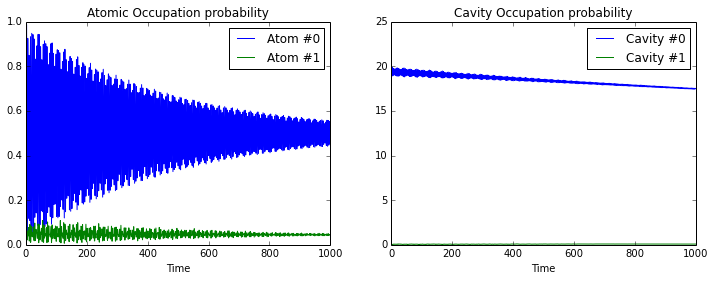

In [13]:
fig, axes = subplots(1, 2, sharex=True, figsize=(12,4))

for m in range(M):
    axes[0].plot(tlist, real(output.expect[m]), label="Atom #%d" % m)

axes[0].legend(loc=0)
axes[0].set_xlabel('Time')
axes[0].set_title('Atomic Occupation probability')

for m in range(M):
    axes[1].plot(tlist, real(output.expect[M+m]), label="Cavity #%d" % m)

axes[1].legend(loc=0)
axes[1].set_xlabel('Time')
axes[1].set_title('Cavity Occupation probability');

For $g > g_c$, the energy is localized in one cavity-atom system. See Fig. 2 in Schmidt et al.

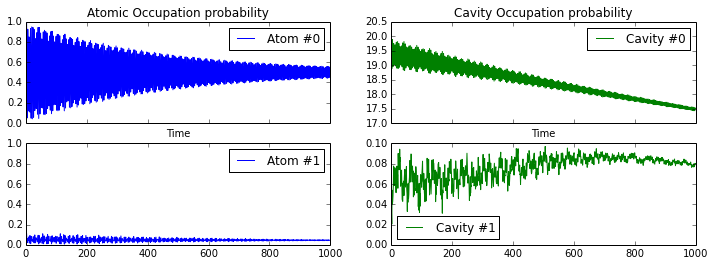

In [14]:
fig, axes = subplots(M, 2, sharex=True, figsize=(12,2*M))

for m in range(M):
    axes[m,0].plot(tlist, real(output.expect[m]), 'b', label="Atom #%d" % m)
    axes[m,0].legend(loc=0)
    axes[m,0].set_ylim(0,1)

    axes[m,1].plot(tlist, real(output.expect[M+m]), 'g', label="Cavity #%d" % m)
    axes[m,1].legend(loc=0)

    if m == 0:
        axes[m,0].set_xlabel('Time')
        axes[m,1].set_xlabel('Time')
        axes[m,0].set_title('Atomic Occupation probability')
        axes[m,1].set_title('Cavity Occupation probability')

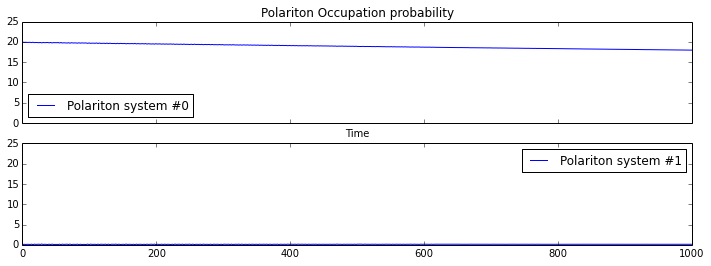

In [15]:
"""
Plot polaritons
"""
fig, axes = subplots(M, 1, sharex=True, sharey=True, figsize=(12,2*M))

for m in range(M):
    axes[m].plot(tlist, real(output.expect[2*M+m]), label="Polariton system #%d" % m)
    axes[m].legend(loc=0)

    if m == 0:
        axes[m].set_xlabel('Time')
        axes[m].set_title('Polariton Occupation probability')

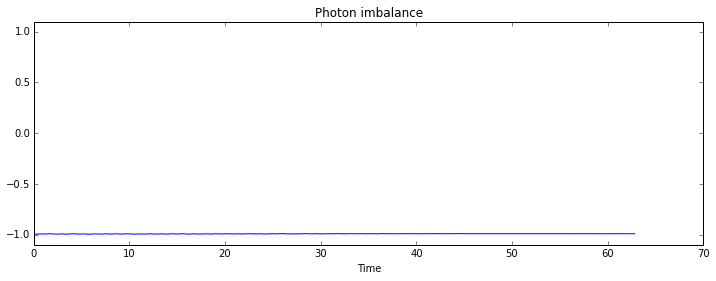

In [16]:
"""
Plot photon imbalance
"""

n = output.expect[3*M] / output.expect[3*M+1]

fig, axes = subplots(1, 1, sharex=True, sharey=True, figsize=(12,2*M))

axes.plot(tlist * J, n, label="Photon imbalance")
axes.set_xlabel('Time')
axes.set_ylim(-1.1, 1.1)
axes.set_title('Photon imbalance');

Large photon imbalance ($\sim - 1$) shows that the energy is localized in one cavity-atom system.